### Lectura de archivos e importación de librerías

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from scipy.stats import shapiro

Buscar base de colegios con numero de alumnos y cantidad de niños que comen con junaeb


In [6]:
data = pd.read_excel("../Data/Consolidado2022/Junio_JUNAEB.xlsx", sheet_name=1)

In [7]:
data.head(5)

,Servicio,Precio por racion,Dias,Raciones diarias,Racion*$*Dias,Racion*Dias,$Racion/dia,Unnamed: 7
0,T,947.30,1,60,56838.0,60,1134.894953,567.447476
1,D,1023.46,1,60,61407.6,60,NaN,NaN
2,A,1335.20,1,60,80112.0,60,NaN,NaN
3,D,889.66,20,134,2384288.8,2680,NaN,NaN
4,A,1683.80,20,134,4512584.0,2680,NaN,NaN


### Preprocesamiento

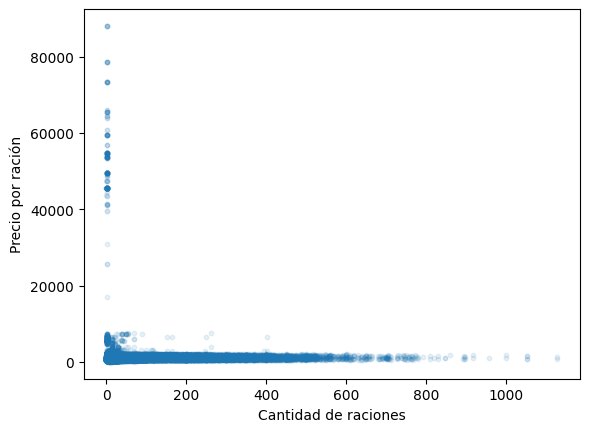

In [8]:
M = 100000
filtro = data["Precio por racion"] < M

raciones = data["Raciones diarias"]
precio = data["Precio por racion"]
plt.scatter(raciones[filtro], precio[filtro], s=10, alpha=0.1)
plt.xlabel("Cantidad de raciones")
plt.ylabel("Precio por ración");

ahora se agruparán los puntos que corresponden a raciones con el mismo precio 

In [9]:
print(len(set(precio)), len(precio))

precio_unico = np.array(sorted(set(precio)))

499 61908


In [10]:
raciones_por_precio = np.array([sum(raciones[precio == p]) for p in precio_unico])

Generamos filtros y visualizamos

Text(0.5, 1.0, 'datos de Junio de consolidado2020')

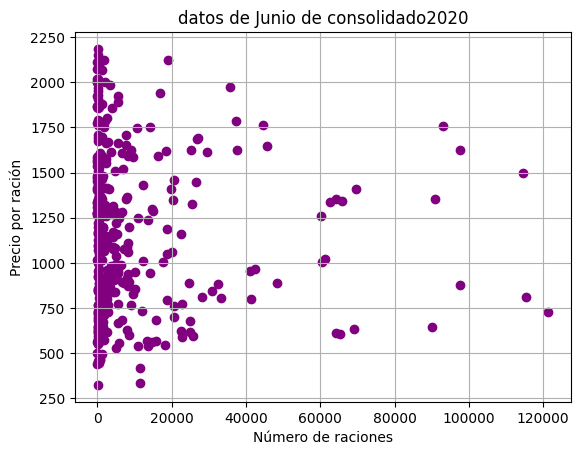

In [35]:
filtro1 = precio_unico < 2250
filtro2 = precio_unico > 0
filtro3 = raciones_por_precio > 0
filtro = np.logical_and(filtro1, filtro2, filtro3)
plt.scatter(raciones_por_precio[filtro], precio_unico[filtro], color='purple')
plt.xlabel('Número de raciones')
plt.ylabel('Precio por ración')
plt.grid(True)
plt.title('datos de Junio de consolidado2020')


Resumen de estadísticas relevantes

In [12]:
clean_data = pd.DataFrame({'raciones_diarias': raciones_por_precio[filtro], 'precio_racion': precio_unico[filtro]})

# Estadísticas de los datos
model = smf.ols('precio_racion ~ raciones_diarias', data=clean_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          precio_racion   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                 8.258e-05
Date:                Thu, 28 Sep 2023   Prob (F-statistic):              0.993
Time:                        18:50:09   Log-Likelihood:                -2938.4
No. Observations:                 394   AIC:                             5881.
Df Residuals:                     392   BIC:                             5889.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1122.9997     23.430  

Realizamos test para probar supuestos de homeocedasticidad, normalidad (shapiro-wilks ta pendiente), ...

In [13]:

names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
test_result = sms.het_breuschpagan(model.resid, model.model.exog)
 
lzip(names, test_result)

[('Lagrange multiplier statistic', 0.28175281382930617),
 ('p-value', 0.5955546552916529),
 ('f-value', 0.2805232010718986),
 ('f p-value', 0.5966583267065603)]

In [14]:
log_raciones_precio = np.log(raciones_por_precio[filtro])
log_precio_unico = np.log(precio_unico[filtro])

In [15]:
log_data = pd.DataFrame({'log_raciones_precio': log_raciones_precio,
                         'log_precio_unico': log_precio_unico})

<Axes: xlabel='log_raciones_precio', ylabel='log_precio_unico'>

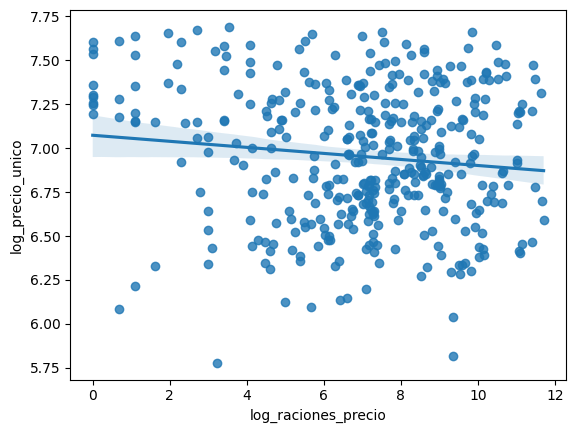

In [17]:
sns.regplot(x='log_raciones_precio', y='log_precio_unico', data=log_data)

In [18]:
model = smf.ols('log_precio_unico ~ log_raciones_precio', data=log_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       log_precio_unico   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.542
Date:                Thu, 28 Sep 2023   Prob (F-statistic):             0.0191
Time:                        18:50:09   Log-Likelihood:                -179.56
No. Observations:                 394   AIC:                             363.1
Df Residuals:                     392   BIC:                             371.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.0728    

In [19]:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
# Get the test result
test_result = sms.het_breuschpagan(model.resid, model.model.exog)
 
lzip(names, test_result)

[('Lagrange multiplier statistic', 3.4183301334806577),
 ('p-value', 0.06447620153724552),
 ('f-value', 3.430743211227381),
 ('f p-value', 0.06474488374566581)]

### 3. Regresión lineal a log datos

In [20]:
modelo = LinearRegression()
log_raciones_precio = log_raciones_precio.reshape(-1, 1)
log_precio_unico = log_precio_unico.reshape(-1, 1)
modelo.fit(X=log_raciones_precio, y=log_precio_unico);

In [21]:
m = modelo.coef_[0][0]
b = modelo.intercept_[0]

In [28]:
print(f'Intercepto: {round(m,3)}')
print(f'Pendiente: {round(b,3)}')

Intercepto: -0.017
Pendiente: 7.073


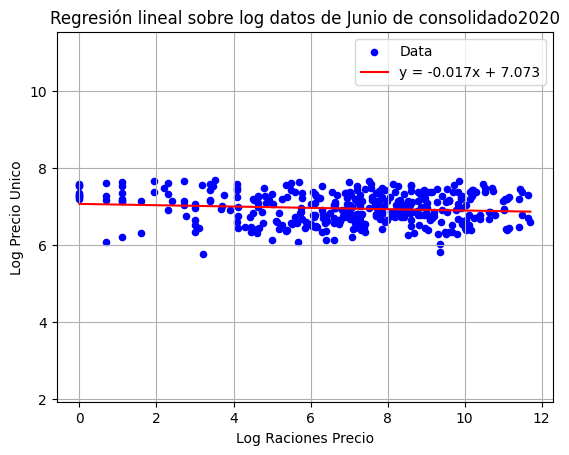

In [29]:
x = np.linspace(min(log_raciones_precio) + 0.001, max(log_raciones_precio), 100)

y = m * x + b
plt.scatter(log_raciones_precio, log_precio_unico, label='Data', color='blue', s=20)

plt.plot(x, y, label=f'y = {round(m,3)}x + {round(b,3)}', color='red')
plt.xlabel('Log Raciones Precio')
plt.ylabel('Log Precio Unico')
plt.legend()

plt.grid(True)
plt.title('Regresión lineal sobre log datos de Junio de consolidado2020')
plt.axis('equal')
plt.show()

In [30]:
r_squared = modelo.score(log_raciones_precio, log_precio_unico)
print(r_squared)

0.01393972986946379


### 4. Ajuste sobre datos originales

In [31]:
X = raciones_por_precio[filtro]
Y = precio_unico[filtro]

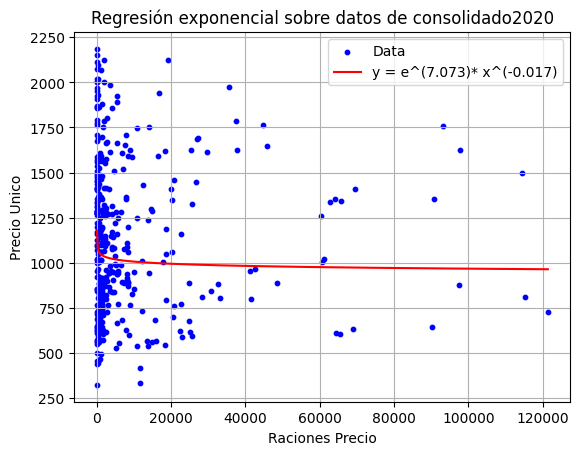

In [32]:
x = np.linspace(min(X) + 0.001, max(X), 500)
y = np.exp(b) * x**m

plt.scatter(X, Y, label='Data', color='blue', s=10)

plt.plot(x, y, label=f'y = e^({round(b,3)})* x^({round(m,3)})', color='red')
plt.xlabel('Raciones Precio')
plt.ylabel('Precio Unico')
plt.legend()

plt.grid(True)
plt.title('Regresión exponencial sobre datos de consolidado2020')
plt.show()

In [33]:
np.exp(b)

1179.4121017400564

### 5. Regresión lineal sobre datos consolidado

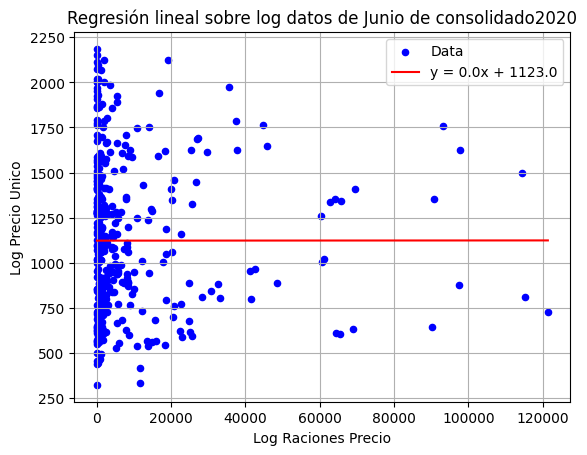

In [34]:
modelo = LinearRegression()
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
modelo.fit(X, Y)

m = modelo.coef_[0][0]
b = modelo.intercept_[0]

x = np.linspace(min(X) + 0.001, max(X), 500)
y = m * x + b
plt.scatter(X, Y, label='Data', color='blue', s=20)

plt.plot(x, y, label=f'y = {round(m,3)}x + {round(b,3)}', color='red')
plt.xlabel('Log Raciones Precio')
plt.ylabel('Log Precio Unico')
plt.legend()

plt.grid(True)
plt.title('Regresión lineal sobre log datos de Junio de consolidado2020')
plt.show()